In [2]:
from builtins import enumerate

print(__doc__)

# from sklearn import cross_validation
from sklearn import metrics
from sklearn.model_selection import KFold
import numpy as np

from skfusion import datasets
from skfusion import fusion as skf

import sys
#sys.path.append('/mag/scripts')
sys.path.append('/home/lpodgorsek/mag/scripts')
import utilityFunctions as uf
import base2
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl


%load_ext autoreload
%autoreload 2

Automatically created module for IPython interactive environment


In [3]:
dicty = datasets.load_dicty()
gene = dicty.get_object_type("Gene")
go_term = dicty.get_object_type("GO term")
exp_cond = dicty.get_object_type("Experimental condition")

dicty[gene][go_term][0].data = base2.resize_rows_and_columns_data(dicty[gene][go_term][0].data, 2)
dicty[gene][exp_cond][0].data = base2.resize_rows_and_columns_data(dicty[gene][exp_cond][0].data, 2)
dicty[gene][gene][0].data = base2.resize_rows_and_columns_data(dicty[gene][gene][0].data, 2)

dicty[gene][go_term][0].data = uf.normalization(dicty[gene][go_term][0].data)
dicty[gene][exp_cond][0].data = uf.normalization(dicty[gene][exp_cond][0].data)
dicty[gene][gene][0].data = uf.normalization(dicty[gene][gene][0].data)

dicty[gene][go_term][0].data = uf.order_by_clustering(dicty[gene][go_term][0].data, 'single')
dicty[gene][exp_cond][0].data = uf.order_by_clustering(dicty[gene][exp_cond][0].data, 'single')
dicty[gene][gene][0].data = uf.order_by_clustering(dicty[gene][gene][0].data, 'single')

n_folds = 10
n_genes = dicty[gene][go_term][0].data.shape[0]

kfold = KFold(n_splits=n_folds)
fold_mse = np.zeros(n_folds)
ann_mask = np.zeros_like(dicty[gene][go_term][0].data).astype('bool')

relations = [
    skf.Relation(dicty[gene][go_term][0].data, gene, go_term),
    skf.Relation(dicty[gene][exp_cond][0].data, gene, exp_cond),
    skf.Relation(dicty[gene][gene][0].data, gene, gene)]
fusion_graph = skf.FusionGraph(relations)
fuser = skf.Dfmc(max_iter=30, n_run=1, init_type='random', random_state=0)


org_data_DFMF = dicty[gene][go_term][0].data
predict_DFMF = np.empty((0, 128))

data_idx = [x for x in range(n_genes)]
for i, (train_idx, test_idx) in enumerate(kfold.split(data_idx)):
    ann_mask[:] = False
    ann_mask[test_idx, :] = True
    fusion_graph[gene][go_term][0].mask = ann_mask

    fuser.fuse(fusion_graph)
    pred_ann = fuser.complete(fuser.fusion_graph[gene][go_term][0])[test_idx]
    true_ann = dicty[gene][go_term][0].data[test_idx]
    fold_mse[i] = metrics.mean_squared_error(pred_ann, true_ann)
    predict_DFMF = np.r_[predict_DFMF, pred_ann]

print("MSE: %5.4f" % np.mean(fold_mse))

MSE: 0.0331


-0.6036839683929892
1.4460701080431675


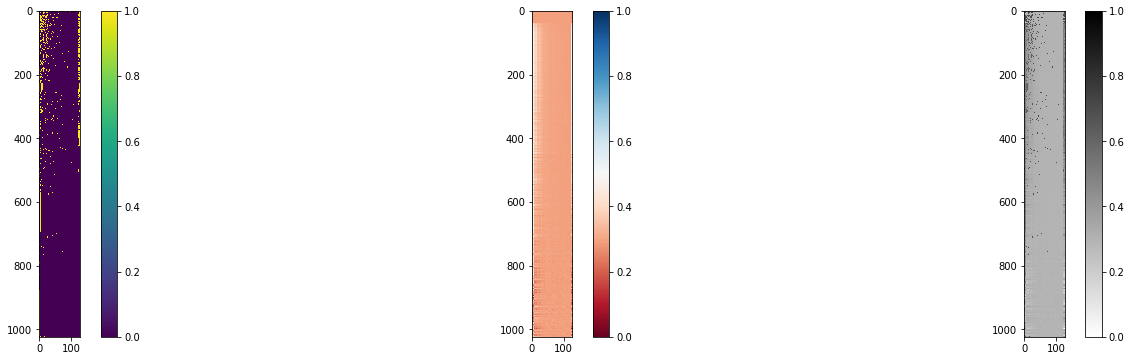

In [4]:
org_data = dicty[gene][go_term][0].data
predict = predict_DFMF

color_pack = 'viridis'
color_pack2 = 'RdBu'
color_pack3 = 'binary'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,6))

print(np.min(predict))
print(np.max(predict))

predict = predict - np.min(predict)
predict = predict / np.max(predict)


ax = axes[0]
im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

ax = axes[1]
im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

ax = axes[2]
im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))

# fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
cax,kw = mpl.colorbar.make_axes([axes[0]])
cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
cax3,kw3 = mpl.colorbar.make_axes([axes[2]])

cba = plt.colorbar(im, cax=cax, **kw)
cbb = plt.colorbar(im2, cax=cax2, **kw2)
cbc = plt.colorbar(im3, cax=cax3, **kw3)

path= '//home/lpodgorsek/mag/Final Results/data_fusion_matrix_factorization/'
numOfExperiment = 13
plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

plt.show()

In [5]:
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data

test_cells = load_test_cells('/home/lpodgorsek/data/cnn/dicty/_00/samples_ann.npz')
predict_cells = []
org_cells = []
# test_cells = test_cells[:10]

avg_diff = 0
predict_data = predict_DFMF.flatten()
print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
print("---------------------------------------------------------------------------------------")
for i in range(len(test_cells)):
    org_val = test_cells[i][1]
    predict_val = predict_data[test_cells[i][0]]
    diff_abs = np.abs(org_val - predict_val)
    print(str(test_cells[i]) + ' ' + format(predict_val, '.5f') + ' ' + format(org_val, '.5f') + ' ' + format(diff_abs, '.5f') )
    
    avg_diff += diff_abs
    org_cells.append([test_cells[i][0], test_cells[i][1]])
    predict_cells.append([test_cells[i][0], predict_val])
    

print()
print("---------------------------------------------------------------------------------------")

val = avg_diff*100/len(test_cells)
print("\t\t" + format(val, '.5f') + "%", end="\t")
print()

Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 0.55107 1.00000 0.44893
(32635, 1.0) 0.32214 1.00000 0.67786
(2436, 1.0) 0.00000 1.00000 1.00000
(55808, 1.0) 0.87142 1.00000 0.12858
(44159, 1.0) 0.52160 1.00000 0.47840
(25344, 1.0) 0.82710 1.00000 0.17290
(31237, 1.0) 0.56067 1.00000 0.43933
(78080, 1.0) 0.83200 1.00000 0.16800
(38809, 1.0) 0.08171 1.00000 0.91829
(55061, 1.0) 0.11286 1.00000 0.88714
(21760, 1.0) 0.90291 1.00000 0.09709
(46974, 1.0) 0.30282 1.00000 0.69718
(126209, 1.0) 0.50736 1.00000 0.49264
(110976, 1.0) 0.35786 1.00000 0.64214
(23294, 1.0) 0.58157 1.00000 0.41843
(39808, 1.0) 0.66218 1.00000 0.33782
(40574, 1.0) 0.45997 1.00000 0.54003
(122625, 1.0) 1.23582 1.00000 0.23582
(17677, 1.0) 0.22051 1.00000 0.77949
(2842, 1.0) 0.00000 1.00000 1.00000
(40200, 1.0) 0.17466 1.00000 0.82534
(30463, 1.0) 0.64366 1.00000 0.35634
(43775, 1.0) 0.39965 1.0000

Prediction greate to one: 74


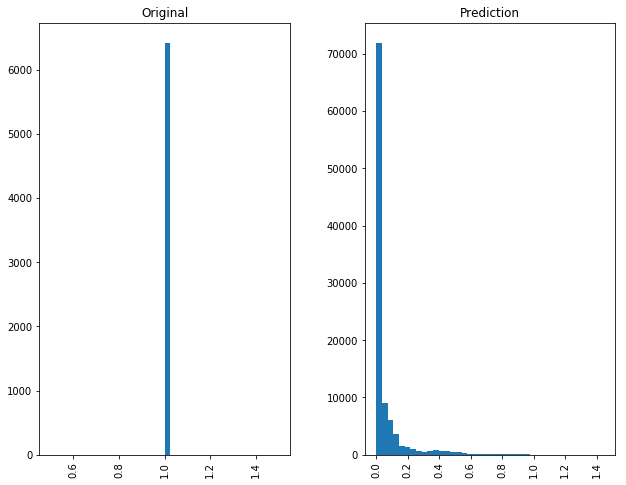

In [12]:
org_data = org_data_DFMF.flatten()
pred_data = predict_DFMF.flatten()

data = org_data[org_data > 0]
indeces = np.zeros(len(org_data[org_data > 0]))

pred_data = pred_data[pred_data > 0]
# pred_data = pred_data[pred_data <= 1.]

data = np.r_[data, pred_data]
indeces = np.r_[indeces, np.ones(len(pred_data))]

new_idx = np.where(indeces == 0, 'Original', indeces)
new_idx = np.where(indeces == 1, 'Prediction', new_idx)

fig, ax = plt.subplots(figsize=(10, 8))
df = pd.DataFrame(data)
df.hist(by=new_idx, bins=40, figsize=(10, 8), ax=ax)
fig.savefig(path + 'histogram_distribution_ann')

print('Prediction greate to one: ' + str(len(pred_data[pred_data > 1])))

/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


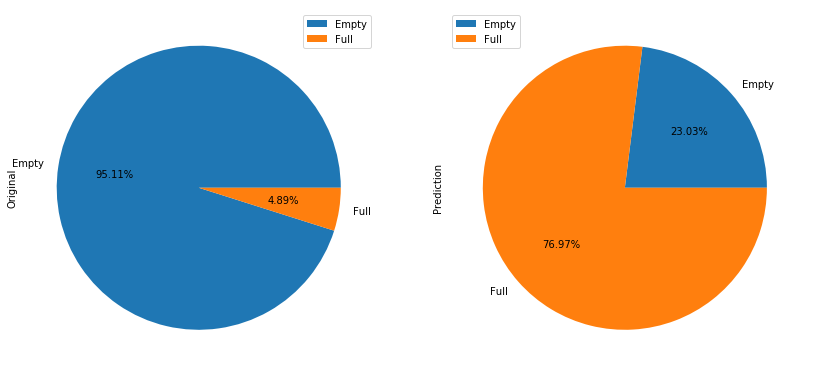

In [13]:
org_data = org_data_DFMF.flatten()
pred_data = predict_DFMF.flatten()

pred_data = pred_data[pred_data > 0]
# pred_data = pred_data[pred_data <= 1.]

length = len(org_data)
d = {}
d['Original'] = []
d['Original'].append(len(org_data[org_data == 0]) / length)
d['Original'].append(len(org_data[org_data > 0]) / length)

d['Prediction'] = []
d['Prediction'].append((length - len(pred_data)) / length)
d['Prediction'].append(len(pred_data) / length)

fig, ax = plt.subplots(figsize=(14,8))
df = pd.DataFrame(d, index=['Empty', 'Full'])
df.plot.pie(subplots=True, figsize=(14, 8), autopct='%.2f%%', ax=ax)
fig.savefig(path + 'pie_density_ann')

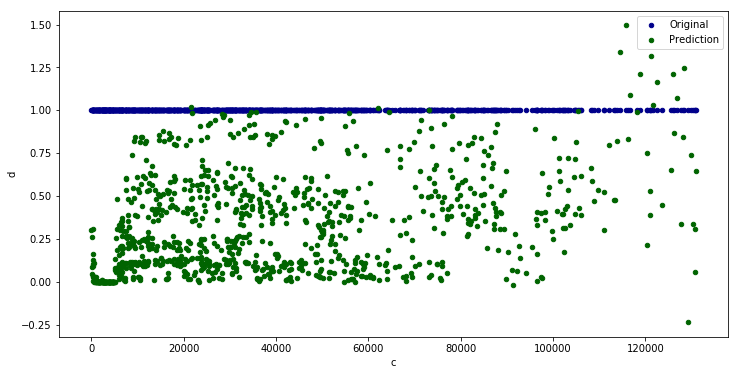

In [77]:
data = []
for i in range(len(org_cells)):
    data.append([org_cells[i][0], org_cells[i][1], predict_cells[i][0], predict_cells[i][1]])


df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])

fig, ax = plt.subplots(figsize=(12,6))
ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original', ax=ax);
ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));
fig.savefig(path + 'scatter_org_vs_prediction_ann.png')

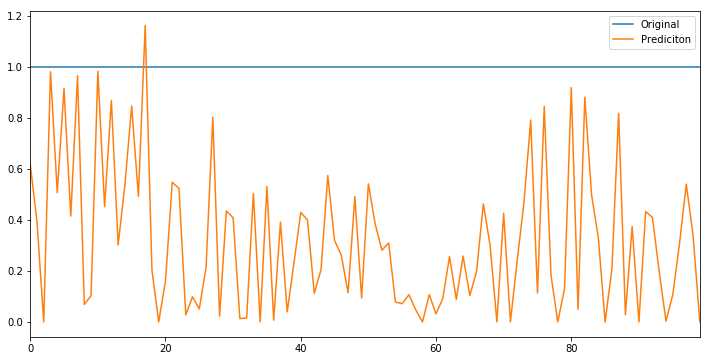

In [73]:
org_data = org_cells
predict_data = predict_cells
data = []
for j in range(len(org_data[:100])):
        data.append([org_data[j][1], predict_data[j][1]])

fig, ax = plt.subplots(figsize=(12,6))
df = pd.DataFrame(data, columns=['Original', 'Prediciton'])
df.plot(subplots=False, figsize=(12,6), ax=ax)
fig.savefig(path + 'graph_org_vs_prediction_ann')